In [9]:
scans_paths = ["case6_gre1.nrrd", "case6_gre2.nrrd"]

def readData(path):
    scans = []
    for scan_path in scans_paths:
        complete_path = path + scan_path
        
        scan = itk.imread(complete_path, itk.F)

        #img = itk.GetArrayFromImage(scan)

        #min_val = img.min()
        #max_val = img.max()
        #img = 255 * (img - min_val) / (max_val - min_val)
        #scan = itk.GetImageFromArray(img)

        scans.append(scan)

    return scans

In [18]:
import itk

def alignData(scan1, scan2, save=None, log=False):
    dimension = scan1.GetImageDimension()
    FixedImageType = type(scan1)
    MovingImageType = type(scan2)

    # Initialiser la transformation
    TransformType = itk.TranslationTransform[itk.D, dimension]
    initial_transform = TransformType.New()


    # Initialiser la métrique
    metric = itk.MeanSquaresImageToImageMetricv4[FixedImageType, MovingImageType].New()
    fixed_interpolation = itk.LinearInterpolateImageFunction[FixedImageType, itk.D].New()
    metric.SetFixedInterpolator(fixed_interpolation)
    metric.SetFixedImage(scan1)
    metric.SetMovingImage(scan2)


    # Initialiser l'optimiseur
    optimizer = itk.RegularStepGradientDescentOptimizerv4.New()

    optimizer.SetLearningRate(1)
    optimizer.SetMinimumStepLength(0.001)
    optimizer.SetNumberOfIterations(400)


    # Configurer le recalage
    RegistrationType = itk.ImageRegistrationMethodv4[FixedImageType, MovingImageType]
    registration = RegistrationType.New()

    registration.SetFixedImage(scan1)
    registration.SetMovingImage(scan2)
    registration.SetMetric(metric)
    registration.SetOptimizer(optimizer)
    registration.SetInitialTransform(initial_transform)


    # Calculer la valeur de la métrique avant le recalage
    metric.Initialize()
    if log:
        initial_metric_value = metric.GetValue()
        print(f"Metric value before transformation: {initial_metric_value}")

    # Effectuer le recalage
    registration.Update()

    # Appliquer la transformation
    resampler = itk.ResampleImageFilter.New(
        Input=scan2,
        Transform=registration.GetTransform(),
        UseReferenceImage=True,
        ReferenceImage=scan1
    )
    aligned_image = resampler.GetOutput()

    if log:
        # Calculer la valeur de la métrique après le recalage
        final_metric_value = metric.GetValue()
        print(f"Metric value after transformation: {final_metric_value}")

    # Sauvegarder l'image recalée
    if save is not None:
        itk.imwrite(aligned_image, save)

        
    print(aligned_image)
    return aligned_image

In [19]:
import itk
import numpy as np

tumor_points = [(82, 69, 49), (124, 63, 79), (98, 77, 82)]

def segmentScan(scan, seed):
    smoother = itk.GradientAnisotropicDiffusionImageFilter.New(Input=scan, NumberOfIterations=20, TimeStep=0.04, ConductanceParameter=3)
    smoother.Update()
    
    connected_threshold = itk.ConnectedThresholdImageFilter.New(smoother.GetOutput())

    connected_threshold.SetReplaceValue(255)
    connected_threshold.SetLower(70)
    connected_threshold.SetUpper(255)
    connected_threshold.SetSeed(seed)
    connected_threshold.Update()
    segmented_image = connected_threshold.GetOutput()

    return segmented_image

def segmentData(scan1, scan2):
    scans = [scan1, scan2]
    segmentations = []
    for scan in scans:
        img = itk.GetArrayFromImage(scan)
        min_val = img.min()
        max_val = img.max()
        img = 255 * (img - min_val) / (max_val - min_val)
        scan = itk.GetImageFromArray(img)
        
        segmentation = np.zeros(scan.shape)
        for tumor_point in tumor_points:
            segmentation = np.maximum(segmentation, segmentScan(scan, tumor_point))
        segmentations.append(segmentation)

    return segmentations

In [20]:
def analyseData(segmentation1, segmentation2):
    print("todo")

In [21]:
def visualizeData(evolution):
    print("todo")

In [22]:
dataPath = "../Data/"
scan1, scan2 = readData(dataPath)

In [23]:
scan2 = alignData(scan1, scan2)

Image (0x5d0ec0218da0)
  RTTI typeinfo:   itk::Image<float, 3u>
  Reference Count: 2
  Modified Time: 7597
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (0x5d0ebfdf5510) 
  Source output name: Primary
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 0
  UpdateMTime: 0
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [0, 0, 0]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [0, 0, 0]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [0, 0, 0]
  Spacing: [1, 1, 1]
  Origin: [0, 0, 0]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
1 0 0
0 1 0
0 0 1

  PointToIndexMatrix: 
1 0 0
0 1 0
0 0 1

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x5d0ec0219060)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, float>
      Reference Count: 1
      Modified Time: 7594
      Debug: Off
      Objec

(0, 0, 0)


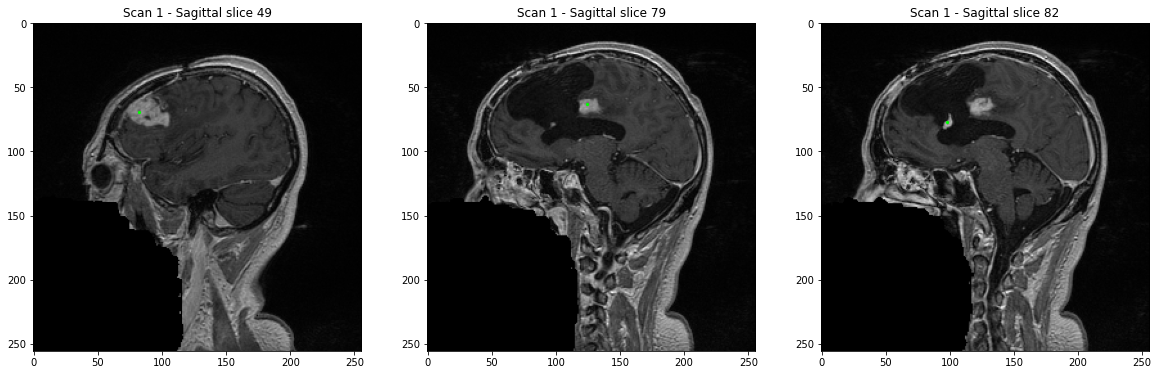

AttributeError: 'NoneType' object has no attribute '__getitem__'

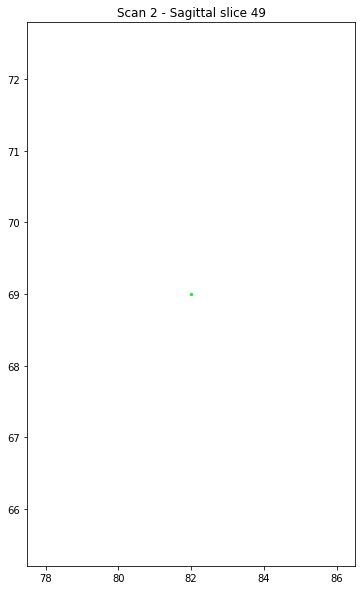

In [17]:
import matplotlib.pyplot as plt

print(scan2.shape)

plt.figure(figsize=(20, 10))

for i in range(3):
    point = tumor_points[i]
    plt.subplot(1, 3, i + 1)

    plt.title("Scan 1 - Sagittal slice " + str(point[2]))
    plt.scatter(point[0], point[1], color='lime', s=5)
    plt.imshow(scan1[point[2], :, :], cmap='gray')

plt.show()

plt.figure(figsize=(20, 10))

for i in range(3):
    point = tumor_points[i]
    plt.subplot(1, 3, i + 1)

    plt.title("Scan 2 - Sagittal slice " + str(point[2]))
    plt.scatter(point[0], point[1], color='lime', s=5)
    plt.imshow(scan2[point[2], :, :], cmap='gray')

plt.show()

In [ ]:
segmentation1, segmentation2 = segmentData(scan1, scan2)

In [ ]:
plt.figure(figsize=(20, 10))

for i in range(3):
    point = tumor_points[i]
    plt.subplot(1, 3, i + 1)

    plt.title("Scan 1 - Sagittal slice " + str(point[2]))
    plt.scatter(point[0], point[1], color='lime', s=5)
    plt.imshow(segmentation1[point[2], :, :], cmap='gray')

plt.show()

plt.figure(figsize=(20, 10))

for i in range(3):
    point = tumor_points[i]
    plt.subplot(1, 3, i + 1)

    plt.title("Scan 2 - Sagittal slice " + str(point[2]))
    plt.scatter(point[0], point[1], color='lime', s=5)
    plt.imshow(segmentation2[point[2], :, :], cmap='gray')

plt.show()

In [ ]:
evolution = analyseData(segmentation1, segmentation2)

In [ ]:
visualizeData(evolution)